# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets


my_btc = 1.2
my_eth = 5.3


In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"


In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()

# Fetch current ETH price
eth_data = requests.get(eth_url).json()
print(json.dumps(btc_data, indent=4))
print(json.dumps(eth_data, indent=4))

In [6]:
# Compute current value of my crpto
my_btc_value=btc_data["data"]["1"]["quotes"]["USD"]["price"]*my_btc
my_eth_value=eth_data["data"]["1027"]["quotes"]["USD"]["price"]*my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $51949.20
The current value of your 5.3 ETH is $16864.76


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [40]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [9]:
# Format current date as ISO format
today = pd.Timestamp("2022-04-01", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today,
    limit=10000
).df


# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY], axis=1, keys=['AGG','SPY'])



# Preview DataFrame
df_portfolio.head()

AGG                                    \
                             open    high     low   close    volume   
timestamp                                                             
2022-04-01 04:00:00+00:00  106.35  106.95  106.25  106.75  11579091   

                                                     SPY                  \
                          trade_count        vwap   open    high     low   
timestamp                                                                  
2022-04-01 04:00:00+00:00       40126  106.667931  453.3  453.46  449.14   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2022-04-01 04:00:00+00:00  452.92  88676014      624745  451.850848

In [39]:
# Pick AGG and SPY close prices

agg_close_price = float(df_portfolio["AGG"]["close"])
spy_close_price = float(df_portfolio["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $106.75
Current SPY closing price: $452.92


In [11]:
# Compute the current value of shares
my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")


The current value of your 200 AGG shares is $21350.00
The current value of your 50 SPY shares is $22646.00


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

value_data = {
    "Crypto": [my_btc_value + my_eth_value],
    "Shares": [my_agg_value + my_spy_value]
}   

# Create savings DataFrame
df_savings = pd.DataFrame(data=[my_btc_value + my_eth_value, my_agg_value + my_spy_value], index = ["Crypto", "Shares"], columns=["Amount"], dtype=float)
# Display savings DataFrame
display(df_savings)

,Amount
Crypto,68813.959
Shares,43996.000


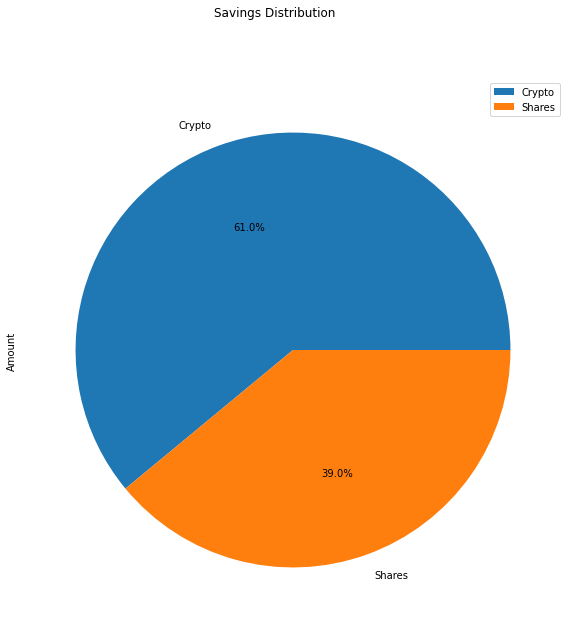

In [13]:
# Plot savings pie chart
df_savings.plot.pie(subplots=True,autopct='%1.1f%%' ,figsize=(20,10),title="Savings Distribution");

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.loc["Crypto","Amount"] + df_savings.loc["Shares", "Amount"]

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations for having enough money in the fund.")
elif total_savings == emergency_fund:
    print("Congratulations on reaching your financial goal")
elif total_savings < emergency_fund:
    print(f"You are {emergency_fund-total_savings} away from reaching your goal!")

Congratulations for having enough money in the fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-04-04', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-04-04', tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit=10000
).df

# Display sample data
df_stock_data

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-04-04 04:00:00+00:00,108.61,108.650,108.5200,108.57,1627492,8325,108.591265,AGG
2017-04-05 04:00:00+00:00,108.48,108.740,108.4530,108.69,2304074,11167,108.599103,AGG
2017-04-06 04:00:00+00:00,108.64,108.710,108.4800,108.68,1725301,7746,108.588276,AGG
2017-04-07 04:00:00+00:00,108.80,108.890,108.4200,108.44,1783599,8534,108.645684,AGG
2017-04-10 04:00:00+00:00,108.53,108.650,108.4901,108.58,1903768,12236,108.566615,AGG
...,...,...,...,...,...,...,...,...
2022-03-29 04:00:00+00:00,460.07,462.070,457.1800,461.53,86682895,738526,459.632992,SPY
2022-03-30 04:00:00+00:00,460.29,461.195,456.4650,458.79,79668682,659199,459.158702,SPY
2022-03-31 04:00:00+00:00,457.92,458.760,451.1600,452.11,118607132,751169,455.444107,SPY


In [17]:
# Reorganize the DataFrame

AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)
                                                       
# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY], axis=1, keys=["AGG","SPY"])

# Display sample data
df_stock_data

AGG                                      \
                             open    high       low   close    volume   
timestamp                                                               
2017-04-04 04:00:00+00:00  108.61  108.65  108.5200  108.57   1627492   
2017-04-05 04:00:00+00:00  108.48  108.74  108.4530  108.69   2304074   
2017-04-06 04:00:00+00:00  108.64  108.71  108.4800  108.68   1725301   
2017-04-07 04:00:00+00:00  108.80  108.89  108.4200  108.44   1783599   
2017-04-10 04:00:00+00:00  108.53  108.65  108.4901  108.58   1903768   
...                           ...     ...       ...     ...       ...   
2022-03-29 04:00:00+00:00  106.61  106.89  106.4550  106.86  11396549   
2022-03-30 04:00:00+00:00  106.60  107.15  106.5900  107.15  11544378   
2022-03-31 04:00:00+00:00  107.19  107.38  107.0600  107.10  13788220   
2022-04-01 04:00:00+00:00  106.35  106.95  106.2500  106.75  11579091   
2022-04-04 04:00:00+00:00  106.87  106.87  106.5600  106.84   9956493   

                                                      SPY                    \
                          trade_count        vwap    open     high      low   
timestamp                                                                     
2017-04-04 04:00:00+00:00        8325  108.591265  235.00  235.580  234.555   
2017-04-05 04:00:00+00:00       11167  108.599103  236.26  237.390  234.540   
2017-04-06 04:00:00+00:00        7746  108.588276  234.96  236.040  234.425   
2017-04-07 04:00:00+00:00        8534  108.645684  235.18  236.000  234.640   
2017-04-10 04:00:00+00:00       12236  108.566615  235.36  236.255  234.730   
...                               ...         ...     ...      ...      ...   
2022-03-29 04:00:00+00:00       33651  106.734051  460.07  462.070  457.180   
2022-03-30 04:00:00+00:00       24975  107.007713  460.29  461.195  456.465   
2022-03-31 04:00:00+00:00       44817  107.229272  457.92  458.760  451.160   
2022-04-01 04:00:00+00:00       40126  106.667931  453.30  453.460  449.140   
2022-04-04 04:00:00+00:00       32544  106.739298  453.20  456.910  452.260   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2017-04-04 04:00:00+00:00  235.48   56466195      192579  235.237449  
2017-04-05 04:00:00+00:00  234.78  108800604      363080  235.933657  
2017-04-06 04:00:00+00:00  235.44   69135757      244996  235.287745  
2017-04-07 04:00:00+00:00  235.20   74412311      235941  235.290964  
2017-04-10 04:00:00+00:00  235.34   67615302      211985  235.487358  
...                           ...        ...         ...         ...  
2022-03-29 04:00:00+00:00  461.53   86682895      738526  459.632992  
2022-03-30 04:00:00+00:00  458.79   79668682      659199  459.158702  
2022-03-31 04:00:00+00:00  452.11  118607132      751169  455.444107  
2022-04-01 04:00:00+00:00  452.92   88676014      624745  451.850848  
2022-04-04 04:00:00+00:00  456.80   59663209      503316  455.309774  

[1260 rows x 14 columns]

In [18]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year_cumulative = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 1000,
    num_trading_days = 252*30
)


In [19]:
# Printing the simulation input data
MC_thirty_year_cumulative.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-04-04 04:00:00+00:00  108.61  108.65  108.5200  108.57  1627492   
2017-04-05 04:00:00+00:00  108.48  108.74  108.4530  108.69  2304074   
2017-04-06 04:00:00+00:00  108.64  108.71  108.4800  108.68  1725301   
2017-04-07 04:00:00+00:00  108.80  108.89  108.4200  108.44  1783599   
2017-04-10 04:00:00+00:00  108.53  108.65  108.4901  108.58  1903768   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-04-04 04:00:00+00:00        8325  108.591265          NaN  235.00   
2017-04-05 04:00:00+00:00       11167  108.599103     0.001105  236.26   
2017-04-06 04:00:00+00:00        7746  108.588276    -0.000092  234.96   
2017-04-07 04:00:00+00:00        8534  108.645684    -0.002208  235.18   
2017-04-10 04:00:00+00:00       12236  108.566615     0.001291  235.36   

                                                                            \
                              high      low   close     volume trade_count   
timestamp                                                                    
2017-04-04 04:00:00+00:00  235.580  234.555  235.48   56466195      192579   
2017-04-05 04:00:00+00:00  237.390  234.540  234.78  108800604      363080   
2017-04-06 04:00:00+00:00  236.040  234.425  235.44   69135757      244996   
2017-04-07 04:00:00+00:00  236.000  234.640  235.20   74412311      235941   
2017-04-10 04:00:00+00:00  236.255  234.730  235.34   67615302      211985   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-04-04 04:00:00+00:00  235.237449          NaN  
2017-04-05 04:00:00+00:00  235.933657    -0.002973  
2017-04-06 04:00:00+00:00  235.287745     0.002811  
2017-04-07 04:00:00+00:00  235.290964    -0.001019  
2017-04-10 04:00:00+00:00  235.487358     0.000595

In [20]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year_cumulative.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006023,1.000096,1.005481,0.990098,1.006073,1.006810,0.990928,1.013596,1.000332,0.993529,...,1.011819,1.000161,0.999693,1.009024,1.010634,0.997321,0.997998,1.003022,1.001137,0.997449
2,0.996725,0.997457,1.007796,0.988864,0.999634,0.998803,0.983313,1.003268,0.992673,0.993229,...,1.018095,0.995981,1.002495,1.010616,1.001123,1.006384,0.987074,1.001896,1.013038,0.986456
3,0.995349,1.010443,1.024305,0.988280,1.003592,0.993811,0.978442,0.988775,0.971191,0.997363,...,1.021781,1.008281,0.995726,1.012272,0.992814,1.005644,0.985098,0.998895,1.007287,0.976448
4,0.995369,1.008619,1.013748,0.987824,1.012363,0.998355,0.993269,0.984972,0.967465,0.998762,...,1.011416,1.002636,0.994789,1.012747,0.998648,1.012606,0.996830,1.010292,0.997832,0.980650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,10.485146,30.347770,3.671987,16.515211,8.805630,10.455756,14.694124,14.520479,13.905385,6.611624,...,14.671616,10.114857,4.248101,15.892763,29.695212,25.507881,9.180572,7.624255,19.742323,8.080765
7557,10.603943,30.326200,3.676994,16.328732,8.961746,10.439063,14.806168,14.500371,13.818645,6.593430,...,14.523365,10.161010,4.234934,15.829998,29.629619,25.582982,9.247748,7.681444,19.809143,8.095097
7558,10.569328,30.578896,3.691729,16.203963,9.001412,10.526597,14.777505,14.531999,13.835023,6.601614,...,14.767615,10.189360,4.249961,15.727877,29.719853,24.934183,9.236999,7.658141,19.703849,7.980022
7559,10.562124,30.585805,3.724360,16.245266,8.859980,10.545145,14.534807,14.529616,13.882541,6.629224,...,14.597653,10.166901,4.315648,15.948451,29.853965,24.692144,9.121381,7.613138,19.689834,7.944734


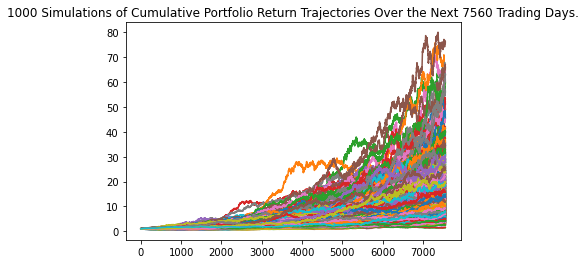

In [21]:
# Plot simulation outcomes
thirty_year_cumulative_line_plot = MC_thirty_year_cumulative.plot_simulation()

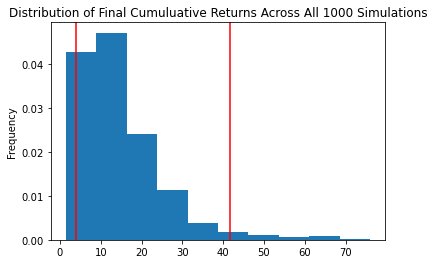

In [22]:
# Plot probability distribution and confidence intervals
thirty_year_cumulative_dist_plot = MC_thirty_year_cumulative.plot_distribution()

### Retirement Analysis

In [23]:
# Fetch summary statistics from the Monte Carlo simulation results
thirty_year_cumulative_tbl = MC_thirty_year_cumulative.summarize_cumulative_return()

# Print summary statistics
print(thirty_year_cumulative_tbl)

count           1000.000000
mean              15.010173
std               10.363469
min                1.416669
25%                7.776194
50%               12.630435
75%               18.936010
max               76.036879
95% CI Lower       3.837668
95% CI Upper      41.554673
Name: 7560, dtype: float64


C:\Users\richi\Desktop\ASU-VIRT-FIN-PT-03-2022-U-LOL\05-APIs\Homework\Instructions\Starter_Code\MCForecastTools.py:174: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [24]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(thirty_year_cumulative_tbl[8]* initial_investment,2)
ci_upper = round(thirty_year_cumulative_tbl[9]* initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $76753.35 and $831093.46


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [25]:
# Set initial investment
initial_investment_increase = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(thirty_year_cumulative_tbl[8]*(initial_investment_increase),2)
ci_upper = round(thirty_year_cumulative_tbl[9]*(initial_investment_increase),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_increase} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $115130.03 and $1246640.2


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [26]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns

MC_five_year_cumulative = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.10,.90],
    num_simulation = 1000,
    num_trading_days = 252*5
)


# Print the simulation input data
MC_five_year_cumulative.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-04-04 04:00:00+00:00  108.61  108.65  108.5200  108.57  1627492   
2017-04-05 04:00:00+00:00  108.48  108.74  108.4530  108.69  2304074   
2017-04-06 04:00:00+00:00  108.64  108.71  108.4800  108.68  1725301   
2017-04-07 04:00:00+00:00  108.80  108.89  108.4200  108.44  1783599   
2017-04-10 04:00:00+00:00  108.53  108.65  108.4901  108.58  1903768   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-04-04 04:00:00+00:00        8325  108.591265          NaN  235.00   
2017-04-05 04:00:00+00:00       11167  108.599103     0.001105  236.26   
2017-04-06 04:00:00+00:00        7746  108.588276    -0.000092  234.96   
2017-04-07 04:00:00+00:00        8534  108.645684    -0.002208  235.18   
2017-04-10 04:00:00+00:00       12236  108.566615     0.001291  235.36   

                                                                            \
                              high      low   close     volume trade_count   
timestamp                                                                    
2017-04-04 04:00:00+00:00  235.580  234.555  235.48   56466195      192579   
2017-04-05 04:00:00+00:00  237.390  234.540  234.78  108800604      363080   
2017-04-06 04:00:00+00:00  236.040  234.425  235.44   69135757      244996   
2017-04-07 04:00:00+00:00  236.000  234.640  235.20   74412311      235941   
2017-04-10 04:00:00+00:00  236.255  234.730  235.34   67615302      211985   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-04-04 04:00:00+00:00  235.237449          NaN  
2017-04-05 04:00:00+00:00  235.933657    -0.002973  
2017-04-06 04:00:00+00:00  235.287745     0.002811  
2017-04-07 04:00:00+00:00  235.290964    -0.001019  
2017-04-10 04:00:00+00:00  235.487358     0.000595

In [27]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year_cumulative.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002497,1.006588,0.981913,1.001018,0.997277,0.992153,1.011905,0.999886,0.997437,1.013352,...,0.989497,1.000149,1.011987,1.008437,1.005354,1.000328,0.994892,1.001688,1.000992,1.010915
2,1.006332,1.001671,0.983690,1.004387,0.980441,0.999049,1.013246,1.009617,1.003778,1.018089,...,0.995454,1.015550,1.035668,1.010648,1.004784,0.994992,1.015022,1.013692,0.988145,1.027608
3,1.010752,0.989345,0.999112,1.002338,0.973541,1.011040,1.018837,0.999792,1.013411,1.001580,...,0.984156,1.033848,1.039148,1.020903,0.991939,0.990341,1.015832,1.012941,0.981993,1.035129
4,1.006090,1.007781,0.993294,0.998747,0.990413,1.003300,1.022446,1.025081,1.010770,1.026390,...,0.964691,1.023839,1.047804,1.036936,0.981325,0.997040,1.021428,1.023038,0.982587,1.015917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.246902,3.637120,1.871914,1.729350,1.179721,3.501154,2.036759,3.622841,2.446407,2.281061,...,2.132723,2.212652,1.885305,2.308651,2.121408,1.602026,0.919224,2.076947,1.539681,0.946729
1257,1.253515,3.590058,1.847255,1.715680,1.174688,3.551340,2.066465,3.581666,2.427719,2.279531,...,2.121337,2.176382,1.858189,2.323309,2.152458,1.586295,0.904435,2.073290,1.551100,0.933415
1258,1.278365,3.516967,1.860099,1.689068,1.159852,3.633379,2.064287,3.609384,2.441710,2.286586,...,2.117626,2.148471,1.875494,2.333212,2.169560,1.576512,0.891795,2.053601,1.584100,0.933228
1259,1.273971,3.534048,1.881281,1.704780,1.180304,3.645862,2.054462,3.614106,2.446977,2.239892,...,2.091506,2.145621,1.857992,2.321535,2.171244,1.573653,0.900087,2.035871,1.589283,0.924794


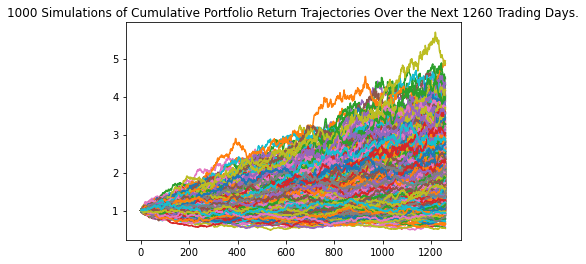

In [28]:
# Plot simulation outcomes
five_year_cumulative_line_plot = MC_five_year_cumulative.plot_simulation()

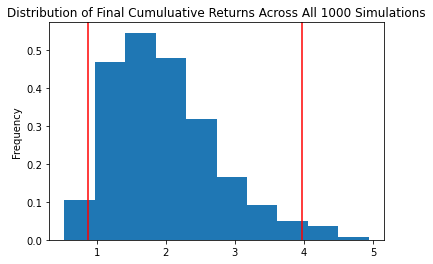

In [29]:
# Plot probability distribution and confidence intervals
five_year_cumulative_dist_plot = MC_five_year_cumulative.plot_distribution()

In [30]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_cumulative_tbl = MC_five_year_cumulative.summarize_cumulative_return()

# Print summary statistics
print(five_year_cumulative_tbl)

count           1000.000000
mean               1.985781
std                0.771022
min                0.530340
25%                1.405073
50%                1.862532
75%                2.410703
max                4.938434
95% CI Lower       0.880202
95% CI Upper       3.976099
Name: 1260, dtype: float64


C:\Users\richi\Desktop\ASU-VIRT-FIN-PT-03-2022-U-LOL\05-APIs\Homework\Instructions\Starter_Code\MCForecastTools.py:174: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [31]:
# Set initial investment
initial_investment_retirement = 500000


# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(five_year_cumulative_tbl[8]*(initial_investment_retirement),2)
ci_upper_five = round(five_year_cumulative_tbl[9]*(initial_investment_retirement),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_retirement} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $500000 in the portfolio over the next 5 years will end within in the range of $440101.18 and $1988049.26


### Ten Years Retirement Option

In [32]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns

MC_ten_year_cumulative = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.25,.75],
    num_simulation = 1000,
    num_trading_days = 252*10
)

# Print the simulation input data
MC_ten_year_cumulative.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-04-04 04:00:00+00:00  108.61  108.65  108.5200  108.57  1627492   
2017-04-05 04:00:00+00:00  108.48  108.74  108.4530  108.69  2304074   
2017-04-06 04:00:00+00:00  108.64  108.71  108.4800  108.68  1725301   
2017-04-07 04:00:00+00:00  108.80  108.89  108.4200  108.44  1783599   
2017-04-10 04:00:00+00:00  108.53  108.65  108.4901  108.58  1903768   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-04-04 04:00:00+00:00        8325  108.591265          NaN  235.00   
2017-04-05 04:00:00+00:00       11167  108.599103     0.001105  236.26   
2017-04-06 04:00:00+00:00        7746  108.588276    -0.000092  234.96   
2017-04-07 04:00:00+00:00        8534  108.645684    -0.002208  235.18   
2017-04-10 04:00:00+00:00       12236  108.566615     0.001291  235.36   

                                                                            \
                              high      low   close     volume trade_count   
timestamp                                                                    
2017-04-04 04:00:00+00:00  235.580  234.555  235.48   56466195      192579   
2017-04-05 04:00:00+00:00  237.390  234.540  234.78  108800604      363080   
2017-04-06 04:00:00+00:00  236.040  234.425  235.44   69135757      244996   
2017-04-07 04:00:00+00:00  236.000  234.640  235.20   74412311      235941   
2017-04-10 04:00:00+00:00  236.255  234.730  235.34   67615302      211985   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-04-04 04:00:00+00:00  235.237449          NaN  
2017-04-05 04:00:00+00:00  235.933657    -0.002973  
2017-04-06 04:00:00+00:00  235.287745     0.002811  
2017-04-07 04:00:00+00:00  235.290964    -0.001019  
2017-04-10 04:00:00+00:00  235.487358     0.000595

In [33]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year_cumulative.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.976894,0.981379,1.009743,1.014929,1.001581,0.998115,0.994438,0.999553,0.992355,0.984731,...,0.992108,1.015986,1.000278,0.990252,1.006622,1.003839,0.997611,1.003707,1.001560,0.985697
2,0.971776,0.977059,0.993375,1.015379,1.002455,0.989513,0.999465,1.001442,0.982977,0.982049,...,1.003286,1.017853,1.010907,0.988413,1.010986,1.013647,0.997571,0.985739,0.992116,0.975037
3,0.970541,0.983329,1.007593,1.021552,0.998947,0.981063,1.013865,1.008625,0.994007,0.978655,...,0.990842,1.030063,1.018364,0.992715,1.022927,1.032184,1.000728,0.975602,1.000159,0.968007
4,0.975327,0.994639,1.007296,1.026552,0.976638,0.983087,1.015555,1.013777,0.995319,0.971020,...,1.003546,1.034913,1.032702,0.990260,1.024835,1.037539,1.002456,0.980526,0.991674,0.957425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,6.774358,3.430400,1.799511,2.526171,3.004812,3.974722,2.550929,1.916116,1.863318,0.636739,...,1.583054,3.004805,3.356213,2.369200,2.145068,2.685862,2.132871,4.577703,3.283866,3.743153
2517,6.768284,3.475926,1.801916,2.506480,3.014406,3.952952,2.568725,1.914152,1.880147,0.646902,...,1.591619,3.025325,3.353774,2.396456,2.158554,2.655782,2.121395,4.585085,3.295280,3.765704
2518,6.789861,3.489261,1.803779,2.481441,3.007664,3.970619,2.606063,1.934205,1.874619,0.642718,...,1.589094,3.006367,3.337268,2.400273,2.151078,2.664901,2.083726,4.570410,3.291644,3.778431
2519,6.763423,3.518254,1.787517,2.517198,3.015417,3.931312,2.593179,1.923305,1.878594,0.649844,...,1.599386,3.023571,3.303789,2.414392,2.175805,2.647715,2.059434,4.664060,3.245451,3.787687


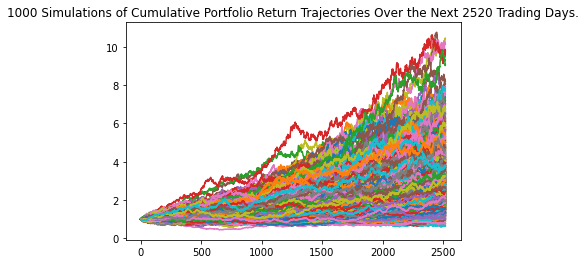

In [34]:
# Plot simulation outcomes
ten_year_cumulative_line_plot = MC_ten_year_cumulative.plot_simulation()

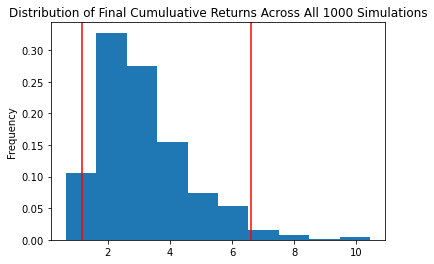

In [35]:
# Plot probability distribution and confidence intervals
ten_year_cumulative_dist_plot = MC_ten_year_cumulative.plot_distribution()

In [36]:
# Fetch summary statistics from the Monte Carlo simulation results
ten_year_cumulative_tbl = MC_ten_year_cumulative.summarize_cumulative_return()

# Print summary statistics
print(ten_year_cumulative_tbl)

count           1000.000000
mean               3.158589
std                1.467691
min                0.648412
25%                2.085835
50%                2.879221
75%                3.850056
max               10.442713
95% CI Lower       1.175514
95% CI Upper       6.611471
Name: 2520, dtype: float64


C:\Users\richi\Desktop\ASU-VIRT-FIN-PT-03-2022-U-LOL\05-APIs\Homework\Instructions\Starter_Code\MCForecastTools.py:174: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [37]:
# Set initial investment
initial_investment_retirement = 500000


# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(ten_year_cumulative_tbl[8]*(initial_investment_retirement),2)
ci_upper_ten = round(ten_year_cumulative_tbl[9]*(initial_investment_retirement),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_retirement} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $500000 in the portfolio over the next 10 years will end within in the range of $587757.05 and $3305735.63
